In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as scs
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

%config InlineBackend.figure_format = 'retina'

# Evaluating Classification Models

Brandon Martin-Anderson, 13 Feb 2019

### Morning: 
* Soft models vs. hard models
* Log Loss
* Confusion matrix
* ROC Curve
* ROC-AUC score

### Afternoon
* Cost-Benefit Matrix
* Profit Curve

Most of today's example will rest on a dataset I've been API-scraping, of JUMP bike locations. I've processed them into "dwell" records, recording instances in which a single bicycle parked at a single location for some amount of time.

This is an important metric for JUMP, because the bikes have some deprication rate, and if a bicycle is underutilized its deprication will grow greater than its revenue and it will lose money.

A simplification:
* A bicycle ride costs \\$2.
* It takes about 5 hours to depricate \\$2. 
* Therefore, a JUMP bike needs to be used on average every 5 hours or else it will lose money. 
* If you can predict if a bike *will* go stale, then you can maybe prevent it from going stale, through relocation or incentives.

In [2]:
#open CSV
df = pd.read_csv("data/sf_jump_dwell.csv")
df.head()

,lon,lat,time0,time1,wait,starttimeseconds,density
0,-122.443055,37.763643,1538192301,1.538245e+09,52719.0,74301,4.0
1,-122.390378,37.789510,1538330909,1.538331e+09,364.0,40109,165.0
2,-122.404305,37.782367,1538414587,1.538420e+09,5895.0,37387,123.0
3,-122.396235,37.788723,1538423945,1.538427e+09,3399.0,46745,287.0
4,-122.421627,37.761098,1538429346,1.538440e+09,10195.0,52146,73.0


Bask in the glory!

Text(0.5, 1.0, 'JUMP bike parking spots')

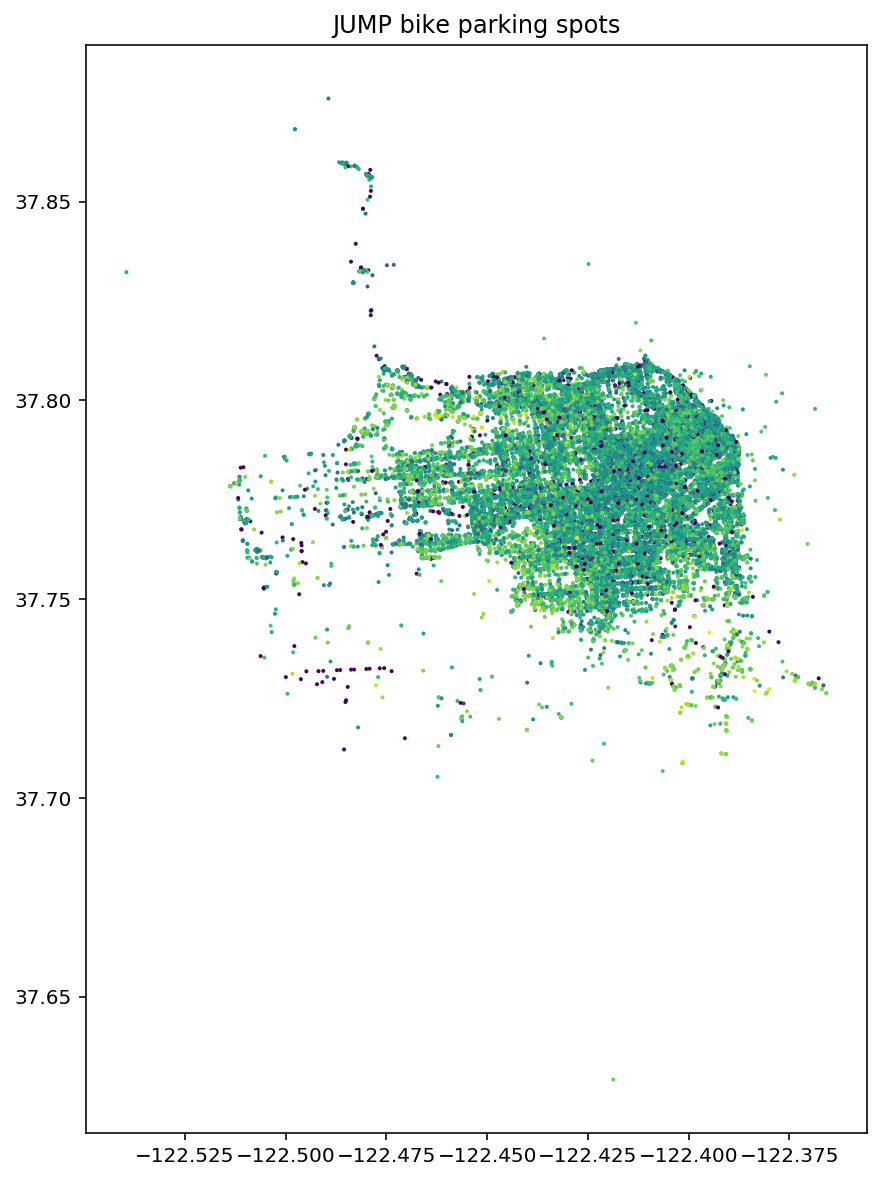

In [3]:
plt.figure(figsize=(7,10))
plt.scatter(df.lon, df.lat, s=1, c=np.log(df.wait+1))
plt.title("JUMP bike parking spots")

We'll define a binary target "stale", as any dwell that lasted longer than five hours.

In [4]:
df["stale"] = (df["wait"]>3600*5)

df = df[df.starttimeseconds > 3600*5.5] #only consider dwells after the early morning

Force class balance.

In [5]:
df = pd.concat( (df[ df.stale ].sample(len(df)//2, replace=True),
                df[ ~df.stale ].sample(len(df)//2, replace=True)) ).sample(frac=1)

At this point I've massaged the data to work well with logistic regression.

* Why would this work well with logistic regression?
* What's challenging to LR about this?

Text(0.5, 1.0, 'Stale bike classification by parking spot density and day lateness')

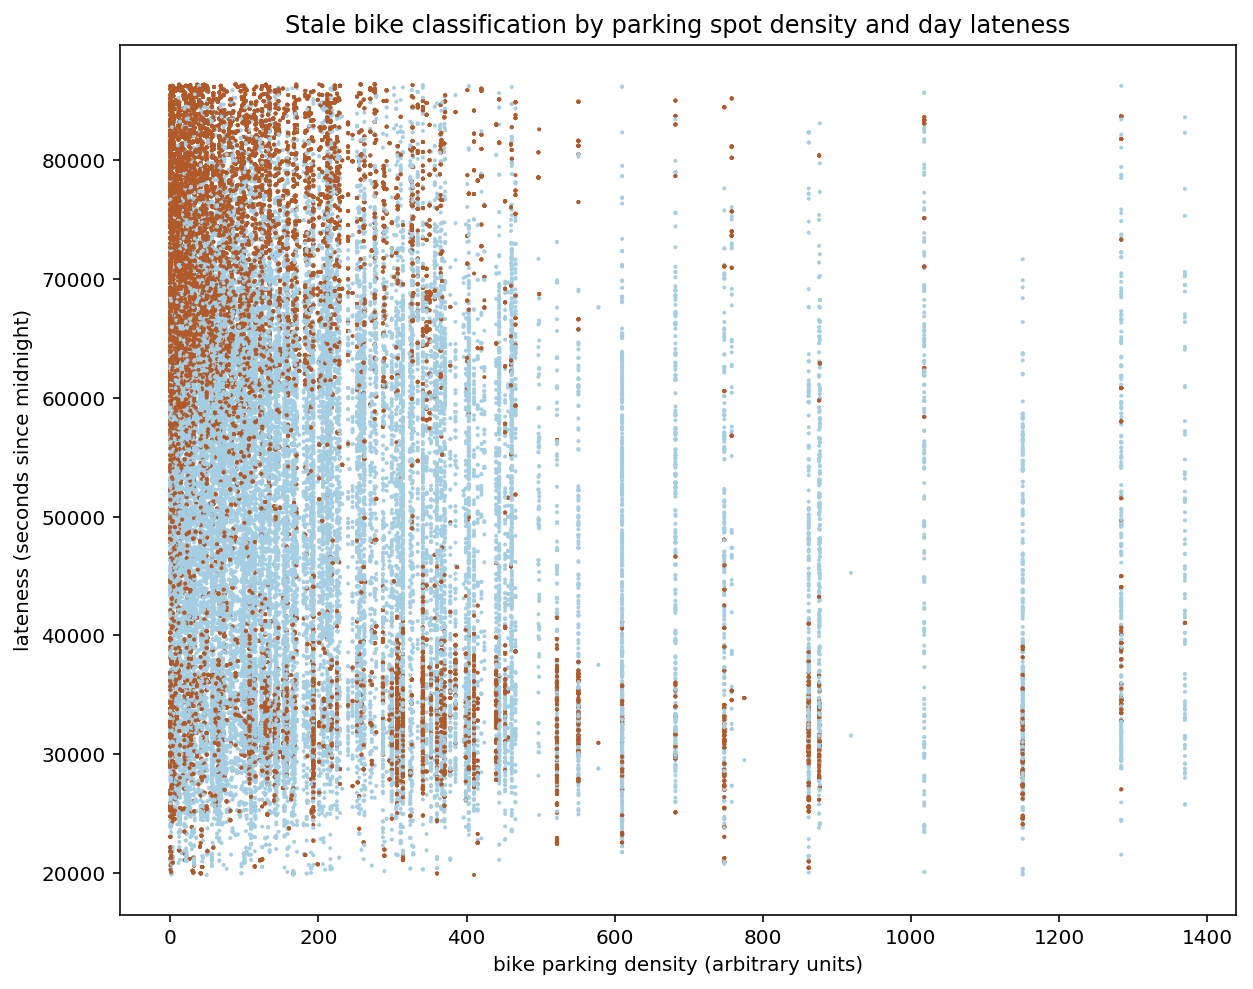

In [6]:

plt.figure(figsize=(10,8))
plt.scatter( df.density, df.starttimeseconds, c=df.stale, s=1, cmap="Paired" )
plt.xlabel("bike parking density (arbitrary units)")
plt.ylabel("lateness (seconds since midnight)")
plt.title("Stale bike classification by parking spot density and day lateness")

## Fitting the Logistic Regression model

First, define the X and y.

In [7]:
X = df[["density","starttimeseconds"]].values
y = df["stale"].values

* What are the dimensions of X?
* What are the dimensions of y?
* What in the world is going on? How does this relate to the map above?

Now, set up the train and test.

* What would be a good split for this dataset?

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42) #it's tradition

In a few deft lines, fit a logistic regression model.

In [9]:
model = LogisticRegression(solver="lbfgs")
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

We can take a look at the probability surface output by this model:

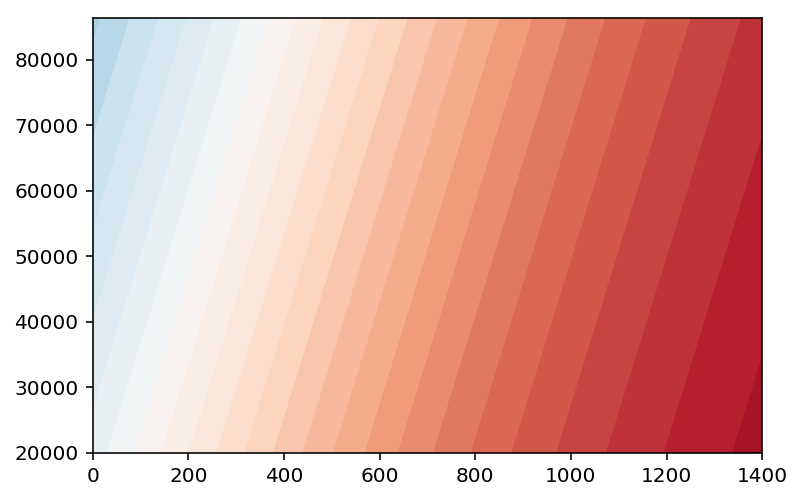

In [11]:
density, lateness = np.meshgrid(np.linspace(0,1400, num=200), 
                                np.linspace(20000, 24*3600, num=200))
grid = np.stack( (density.ravel(), lateness.ravel()) ).T
yhat_prob = model.predict_proba( grid ).T[1].reshape(density.shape)
contour = plt.contourf(density, lateness, yhat_prob, 25, cmap="RdBu",
                      vmin=0, vmax=1.0)

Jumping **RECKLESSLY AND DANGEROUSLY AHEAD**: the abstaction of the model is **very powerful** and makes this workflow **very flexible**. I could, for example, swap in a different model with a few lines of code:

In [17]:
othermodel = RandomForestClassifier() # look ma, no hyperparameters
othermodel.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

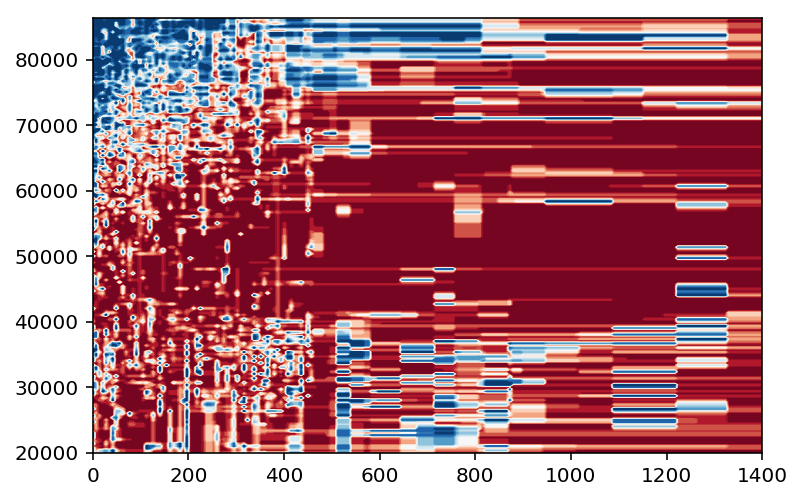

In [18]:
density, lateness = np.meshgrid(np.linspace(0,1400, num=200), 
                                np.linspace(20000, 24*3600, num=200))
grid = np.stack( (density.ravel(), lateness.ravel()) ).T
yhat_prob = othermodel.predict_proba( grid ).T[1].reshape(density.shape)
contour = plt.contourf(density, lateness, yhat_prob, 25, cmap="RdBu",
                      vmin=0, vmax=1.0)

## Back to Logistic Regression

The logistic model fits us a set of parameters $\beta$:

In [21]:
model.coef_, model.intercept_

(array([[-1.75677699e-03,  7.45599811e-06]]), array([-2.98912624e-06]))

Minimizing the loss of this equation:

$$p(x) = \frac{1}{1+e^{-\beta x}}$$

It sure would be handy to be able to plot the linear decision boundaries cutting across the probability surface.

Fortunately we have algebra.

Recall

$$p(x) = \frac{1}{1+e^{-\beta x}}$$
switcheroo
$$1+e^{-\beta x} = \frac{1}{p(x)}$$
subtract from both sides
$$e^{-\beta x} = \frac{1}{p(x)} - 1$$
log of both sides
$$\beta x = -\log{ \big( \frac{1}{p(x)} - 1 \big)}$$
in the convention of high school linear algebra:
$$\beta_0 x + \beta_1 y + b = - \log{ \big( \frac{1}{p(x)} - 1 \big)}$$
isolate y on the left side
$$\beta_1 y = - \log{ \big( \frac{1}{p(x)} - 1 \big)} - \beta_0 x - b$$
finally
$$y = \frac{- \log{ \big( \frac{1}{p(x)} - 1 \big)} - \beta_0 x - b}{\beta_1}$$



In [22]:
# in code form

def get_linear_separator(model, p):
    b0, b1 = model.coef_[0]
    b = model.intercept_
    
    return lambda x: -(np.log(1/p - 1) + b0*x + b)/b1

Now we can plot the linear decision boundaries for different probability thresholds, along with a small subset of the test data. 

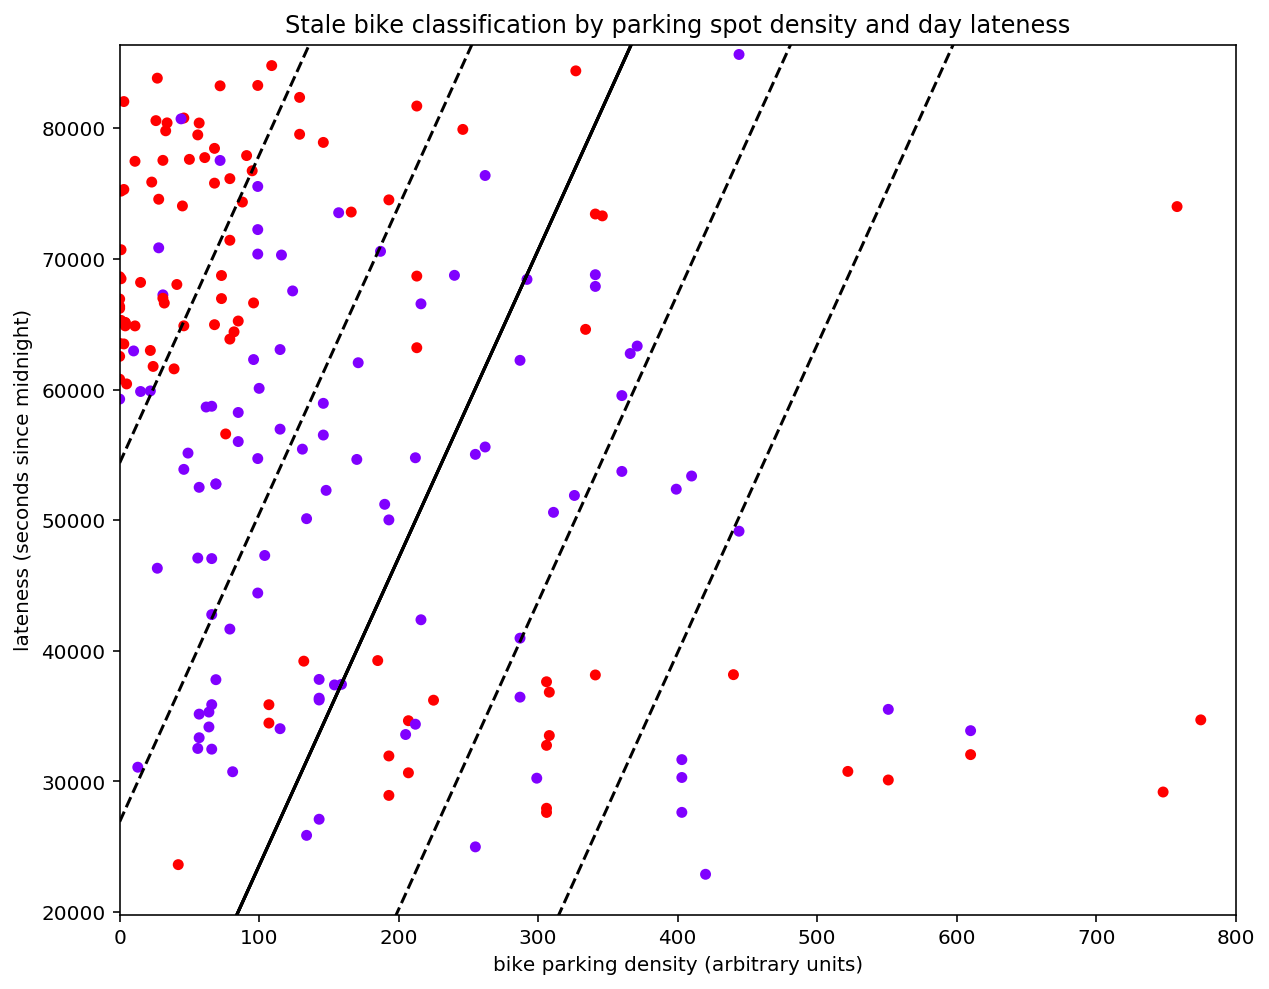

In [23]:
plt.figure(figsize=(10,8))
plt.scatter( X_test[0:200,0], X_test[0:200,1], c=y_test[0:200], s=20, cmap="rainbow" )
plt.xlabel("bike parking density (arbitrary units)")
plt.ylabel("lateness (seconds since midnight)")
plt.title("Stale bike classification by parking spot density and day lateness")
plt.xlim(df.density.min(), 800)
plt.ylim(df.starttimeseconds.min(), df.starttimeseconds.max())

xrange = np.linspace( df.density.min(), df.density.max() )
for i in [0.4, 0.45, 0.55, 0.6]:
    plt.plot(xrange, get_linear_separator(model, i)(xrange), "--", c="black" )
    plt.plot(xrange, get_linear_separator(model, 0.5)(xrange), c="black" )

If we let a threshold p=0.5 for this model inform our predictions, the predictions would look like:

In [79]:
X_test_sub = X_test[:200]
y_test_sub = y_test[:200]

In [80]:
yhat_test = model.predict_proba(X_test_sub).T[1]
yhat_test

array([0.48772252, 0.54005311, 0.43377916, 0.45635017, 0.4737655 ,
       0.51510657, 0.5520522 , 0.54083344, 0.47260922, 0.60373971,
       0.5404806 , 0.49191846, 0.33111089, 0.47848302, 0.59023693,
       0.57342713, 0.56764454, 0.57394269, 0.42770949, 0.24923852,
       0.60872034, 0.46920118, 0.30308664, 0.6173841 , 0.48858004,
       0.2504105 , 0.5813139 , 0.61753228, 0.46628935, 0.56391684,
       0.60845303, 0.62454369, 0.41785383, 0.60962368, 0.47481275,
       0.39807558, 0.63178056, 0.55846544, 0.52557892, 0.3802836 ,
       0.59997442, 0.61600357, 0.21960517, 0.4999406 , 0.62522289,
       0.64053566, 0.6056297 , 0.55393862, 0.53782036, 0.50499543,
       0.6140528 , 0.52917724, 0.56770584, 0.62231599, 0.58054991,
       0.53552559, 0.14332517, 0.42199349, 0.58681142, 0.55057334,
       0.60059558, 0.5795689 , 0.5324122 , 0.60310361, 0.64714171,
       0.60991804, 0.43495857, 0.47369793, 0.60838675, 0.57097536,
       0.5584856 , 0.33456117, 0.58139021, 0.45047773, 0.41843

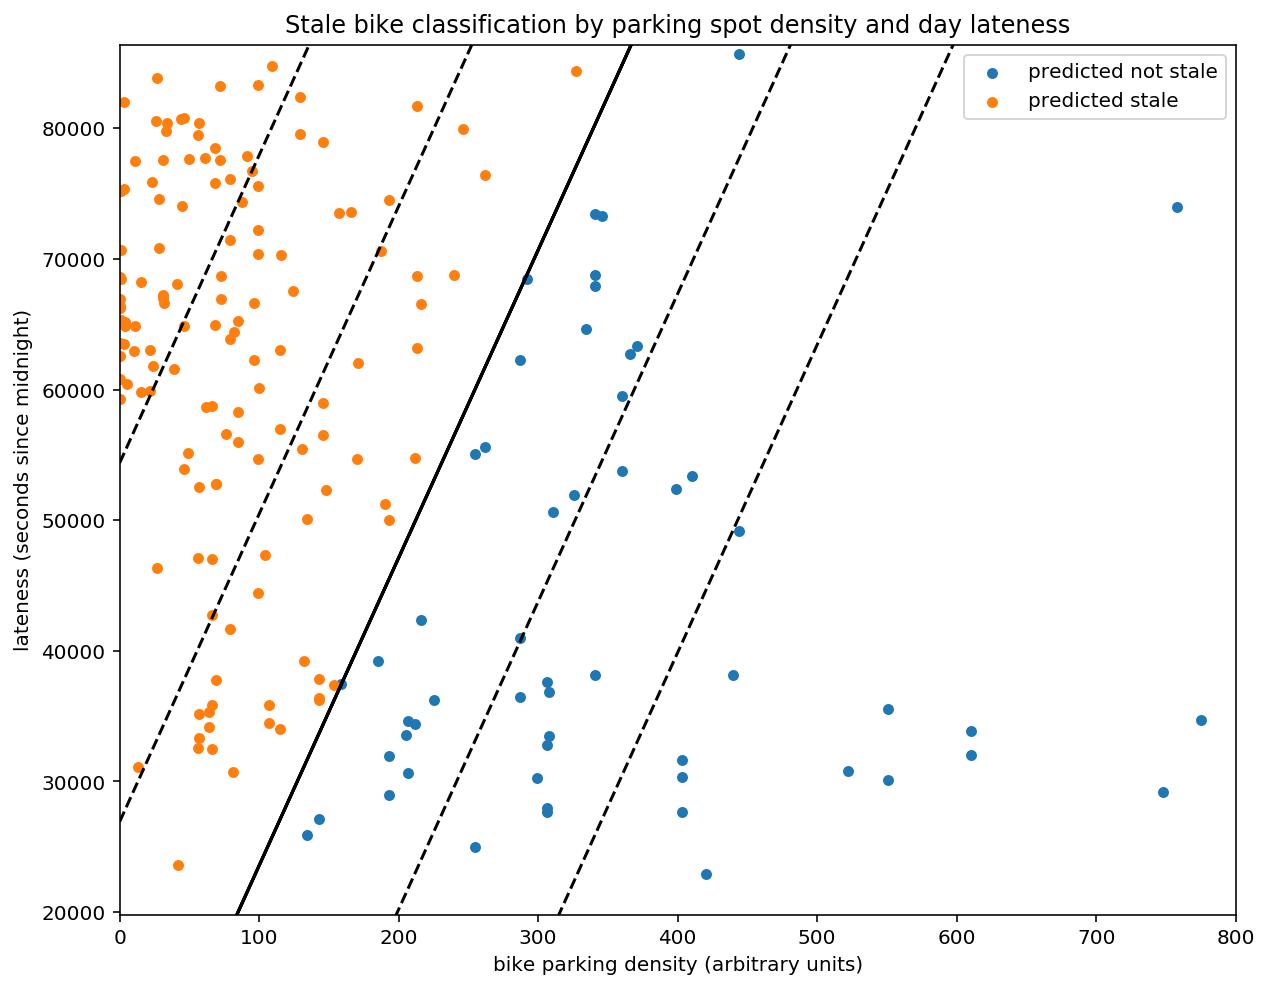

In [81]:
plt.figure(figsize=(10,8))

X_pred_neg = X_test_sub[(yhat_test<0.5)]
X_pred_pos = X_test_sub[(yhat_test>=0.5)]
plt.scatter( X_pred_neg[:,0], X_pred_neg[:,1], s=20, cmap="rainbow", label="predicted not stale" )
plt.scatter( X_pred_pos[:,0], X_pred_pos[:,1], s=20, cmap="rainbow", label="predicted stale" )


plt.xlabel("bike parking density (arbitrary units)")
plt.ylabel("lateness (seconds since midnight)")
plt.title("Stale bike classification by parking spot density and day lateness")
plt.xlim(df.density.min(), 800)
plt.ylim(df.starttimeseconds.min(), df.starttimeseconds.max())

xrange = np.linspace( df.density.min(), df.density.max() )
for i in [0.4, 0.45, 0.55, 0.6]:
    plt.plot(xrange, get_linear_separator(model, i)(xrange), "--", c="black" )
    plt.plot(xrange, get_linear_separator(model, 0.5)(xrange), c="black" )
    
plt.legend()

Alert! Catastophe! This doesn't match the preceding graph! Chastened, we count our failures:

In [82]:
# check out the boolean mask of our predicted negative labels
# all these 
yhat_test < 0.5

array([ True, False,  True,  True,  True, False, False, False,  True,
       False, False,  True,  True,  True, False, False, False, False,
        True,  True, False,  True,  True, False,  True,  True, False,
       False,  True, False, False, False,  True, False,  True,  True,
       False, False, False,  True, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False, False,
       False, False, False,  True,  True, False, False, False,  True,
       False,  True,  True, False, False,  True,  True, False, False,
       False, False, False, False,  True, False, False, False,  True,
       False, False,  True, False, False, False, False,  True, False,
        True, False, False, False, False,  True,  True, False, False,
       False,  True, False, False, False, False, False, False, False,
        True, False, False, False,  True, False, False,  True,  True,
        True, False,

In [84]:
# And this is the boolean array of negative labels, for the test set:
~y_test_sub

array([ True,  True, False,  True, False, False,  True, False,  True,
       False,  True, False,  True,  True, False,  True,  True,  True,
       False, False,  True, False, False, False,  True, False, False,
        True, False, False, False, False, False, False, False,  True,
       False,  True, False, False, False, False,  True,  True, False,
       False, False, False,  True,  True, False,  True,  True, False,
        True,  True,  True, False,  True,  True,  True,  True,  True,
       False, False,  True,  True, False, False,  True, False, False,
        True,  True, False, False, False,  True,  True, False, False,
        True,  True, False, False, False,  True, False,  True, False,
        True,  True,  True,  True, False,  True,  True,  True, False,
        True,  True, False, False,  True,  True,  True, False,  True,
        True,  True, False,  True,  True, False, False, False, False,
        True, False, False,  True,  True,  True, False,  True, False,
        True,  True,

In [85]:
# We can use the boolean `&` operator to find a mask of things that are *both*
true_negative_mask = (yhat_test < 0.5) & ~y_test_sub
true_negative_mask

array([ True, False, False,  True, False, False, False, False,  True,
       False, False, False,  True,  True, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False,  True, False, False, False,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False,  True, False,
        True, False, False, False, False,  True,  True, False, False,
       False,  True, False, False, False, False, False, False, False,
        True, False, False, False,  True, False, False,  True, False,
        True, False,

Using this, we can grab just **true negatives**.

In [86]:
X_test_sub[ true_negative_mask ]

array([[  143., 27106.],
       [  366., 62760.],
       [  205., 33593.],
       [  551., 35518.],
       [  341., 68796.],
       [  262., 55605.],
       [  444., 49158.],
       [  862., 33044.],
       [  159., 37432.],
       [ 1151., 31399.],
       [  255., 24991.],
       [  287., 40968.],
       [ 1284., 50058.],
       [  341., 67898.],
       [  292., 68436.],
       [  610., 33887.],
       [  403., 27633.],
       [  399., 52375.],
       [  403., 31671.],
       [  444., 85656.],
       [  216., 42378.],
       [  326., 51895.],
       [  212., 34381.],
       [  862., 26697.],
       [  420., 22892.],
       [  287., 36454.],
       [  311., 50602.],
       [  360., 59541.],
       [  410., 53383.],
       [  876., 29941.],
       [ 1151., 35943.],
       [ 1151., 34920.],
       [  360., 53735.],
       [  287., 62239.],
       [  134., 25873.],
       [  876., 51033.],
       [  371., 63333.],
       [  255., 55041.],
       [  299., 30250.],
       [  403., 30303.]])

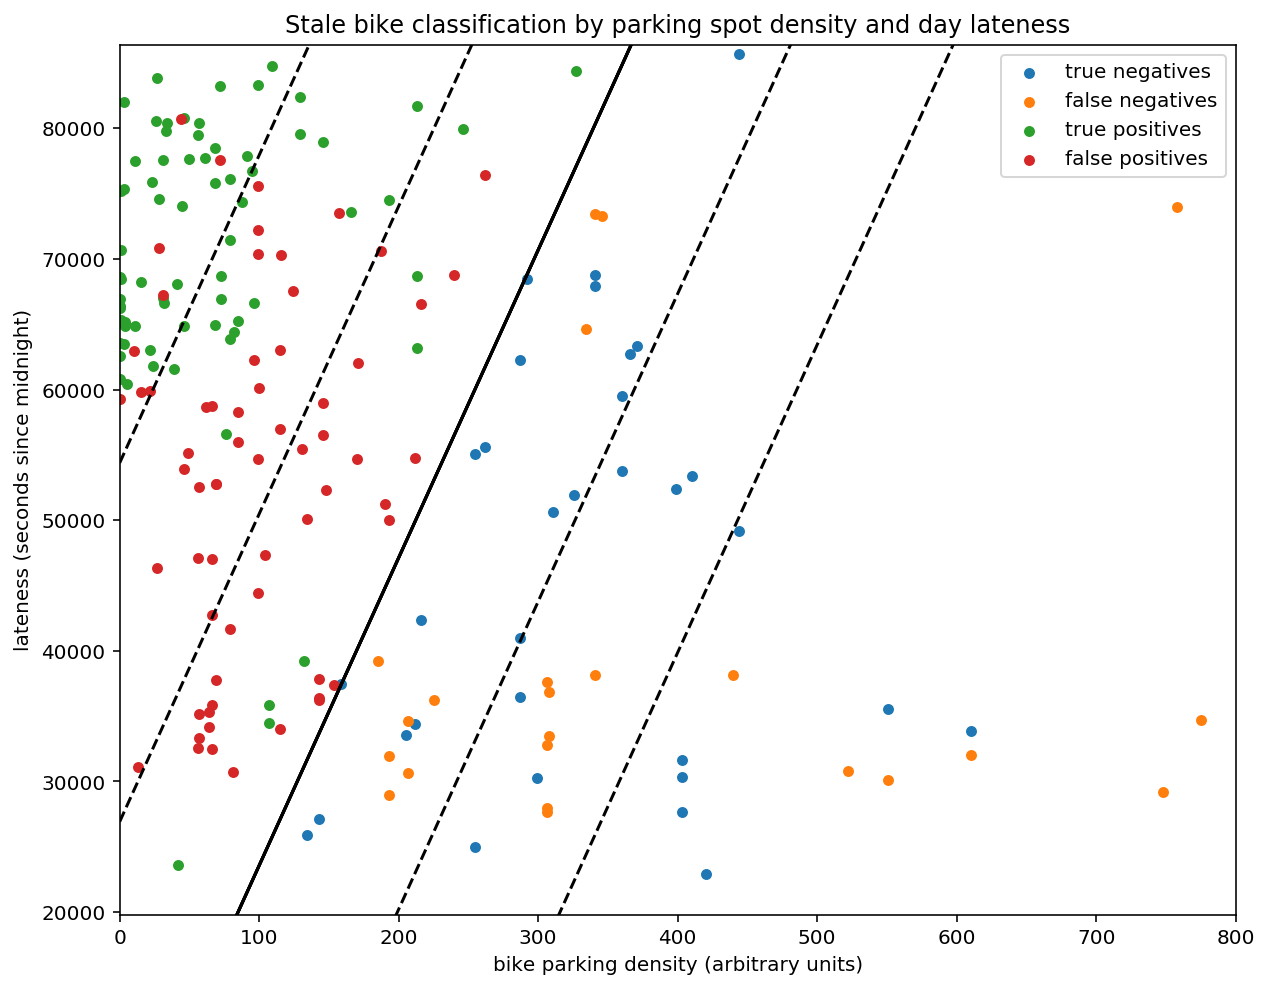

In [97]:
plt.figure(figsize=(10,8))

# true negatives
X_true_neg = X_test_sub[true_negative_mask]
plt.scatter( X_true_neg[:,0], X_true_neg[:,1], s=20, cmap="rainbow", label="true negatives" )

# false negatives
false_negative_mask = (yhat_test < 0.5) & y_test_sub

X_false_neg = X_test_sub[false_negative_mask]
plt.scatter( X_false_neg[:,0], X_false_neg[:,1], s=20, cmap="rainbow", label="false negatives" )

# true positives
true_positive_mask = (yhat_test >= 0.5) & y_test_sub

X_true_pos = X_test_sub[true_positive_mask]
plt.scatter( X_true_pos[:,0], X_true_pos[:,1], s=20, cmap="rainbow", label="true positives" )

# false positives
false_positive_mask = (yhat_test >= 0.5) & ~y_test_sub

X_false_pos = X_test_sub[false_positive_mask]
plt.scatter( X_false_pos[:,0], X_false_pos[:,1], s=20, cmap="rainbow", label="false positives" )


plt.xlabel("bike parking density (arbitrary units)")
plt.ylabel("lateness (seconds since midnight)")
plt.title("Stale bike classification by parking spot density and day lateness")
plt.xlim(df.density.min(), 800)
plt.ylim(df.starttimeseconds.min(), df.starttimeseconds.max())

xrange = np.linspace( df.density.min(), df.density.max() )
for i in [0.4, 0.45, 0.55, 0.6]:
    plt.plot(xrange, get_linear_separator(model, i)(xrange), "--", c="black" )
    plt.plot(xrange, get_linear_separator(model, 0.5)(xrange), c="black" )
    
plt.legend()

We can derive useful statistics by counting these different groups. These are the building blocks for a [dizzing variety](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) of metrics. 

In [98]:
tn = len( X_true_neg ) #true negatives
fn = len( X_false_neg ) #false negatives
tp = len( X_true_pos ) #true positives
fp = len( X_false_pos ) #false positives

tn, fn, tp, fp

(40, 23, 73, 64)

| _  | actual pos  |  actual neg |
|---|---|---|
|  predicted pos | TP: 73  | FP: 64   |
|  predicted neg | FN: 23  | TN: 40   | 

In [103]:
all_positive = fn+tp
all_positive

96

In [105]:
all_negative = fp+tn
all_negative

104

In [106]:
all_pred_pos = tp+fp
all_pred_pos

137

In [107]:
all_pred_neg = fn+tn
all_pred_neg

63

In [110]:
all_correct_pred = tp+tn
all_correct_pred

113

In [111]:
all_incorrect_pred = fp+fn
all_incorrect_pred

87

In [109]:
sample_size = tp+fp+fn+tn
sample_size

200

### Accuracy Score
* "Fraction you got right".
* Intuitive but not very useful.
* **How to game it**: just pick the majority class, especially in imbalanced situations.
 * Never predict cancer, because most people don't have cancer.

In [113]:
accuracy = all_correct_pred/sample_size
accuracy

0.565

### Precision Score

* "Fraction of predictions turned out to be correct"
* **How to game it:** Only make a positive prediction when you're sure.
 * (points to a smashed up car): "there's your problem right there"


In [115]:
precision = tp/all_pred_pos
precision

0.5328467153284672

### Recall Score; True Positive Rate

* "Fraction of findable things found", "probability of detection"
* **How to game it:** Always predict the positive label.
 * Identify every wolf by calling everything a wolf.

In [118]:
recall = tp/all_positive
recall

0.7604166666666666

### False Positive Rate

* "probability of false alarm"
* **How to game it**: Never predict a positive label.
 * You can't get a false alarm if you don't raise the alarm.

In [119]:
fpr = fp/all_negative
fpr

0.6153846153846154

See a theme? **It's easy to cook up a high score for a bad model**. As a result, "good" metrics involve a high *pair* of scores, where gaming one would tank the other.

For example, **precision + recall**. If you game precision (by being very conservative) you can't game recall at the same time (which involves always predicting positive). If a model has both high precision *and* recall, it's more likely to be a generally useful model.

Another important example is **TPR + FPR**. If you game TPR (by always predicting positive) you can't game FPR (which involves always predicting negative). Any model with high FPR+TPR is more likey to perform well generally.

The perfect model would have perfectly high TPR and nonexistent FPR - it would always predict the positive labels correctly but never create any false alarms.

In reality, there's usually a tradeoff between TPR and FPR. Let's explore through examples.

## Gaming True Positive Rate: always predict positive

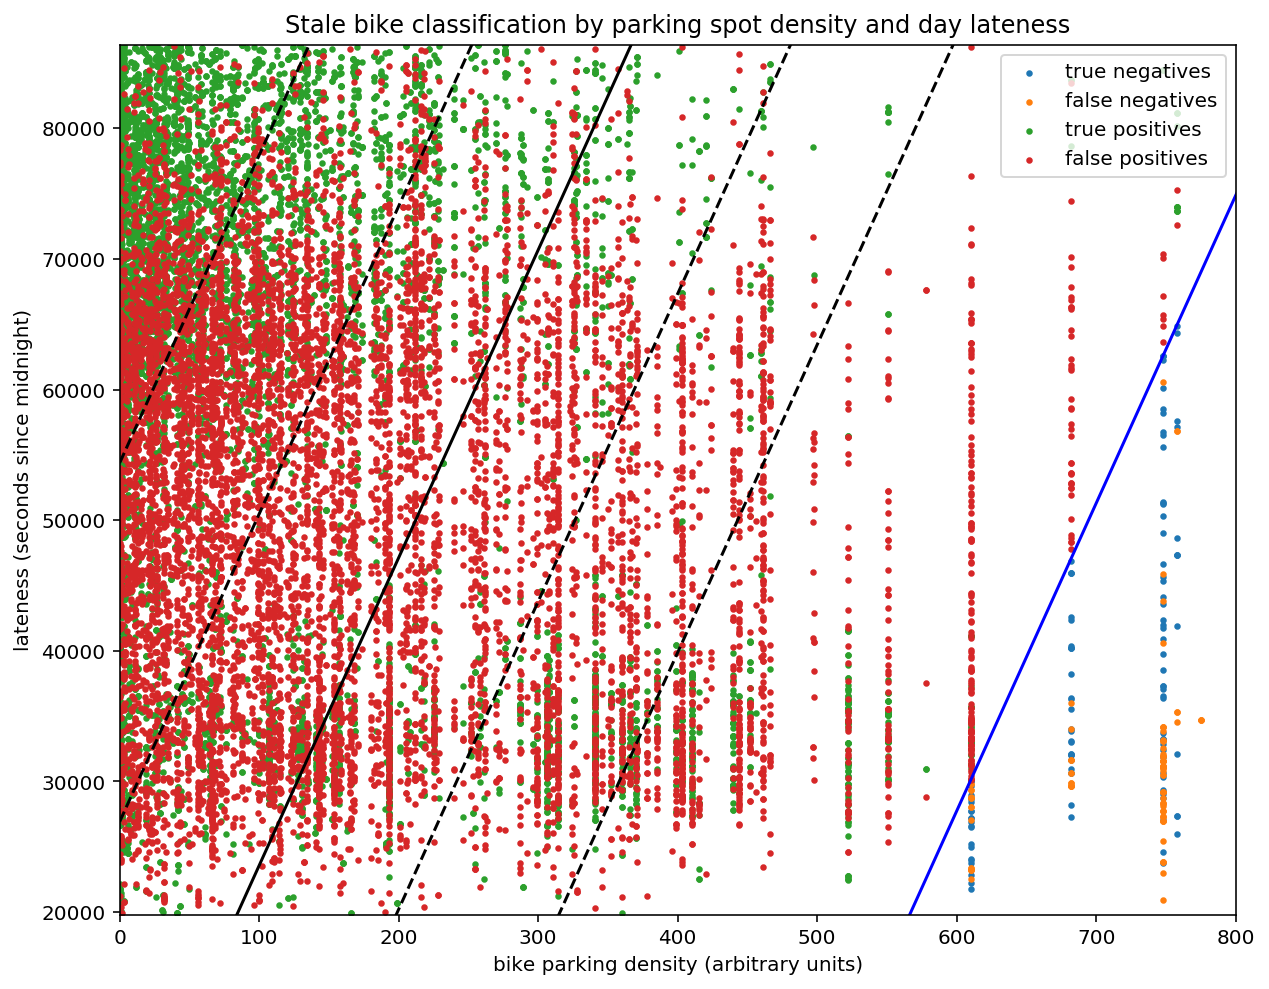

In [132]:
X_test_sub = X_test.copy()
y_test_sub = y_test.copy()

yhat_test = model.predict_proba(X_test_sub).T[1]

alpha = 0.3
s = 5

plt.figure(figsize=(10,8))

# true negatives
true_negative_mask = (yhat_test < alpha) & ~y_test_sub

X_true_neg = X_test_sub[true_negative_mask]
plt.scatter( X_true_neg[:,0], X_true_neg[:,1], s=s, cmap="rainbow", label="true negatives" )

# false negatives
false_negative_mask = (yhat_test < alpha) & y_test_sub

X_false_neg = X_test_sub[false_negative_mask]
plt.scatter( X_false_neg[:,0], X_false_neg[:,1], s=s, cmap="rainbow", label="false negatives" )

# true positives
true_positive_mask = (yhat_test >= alpha) & y_test_sub

X_true_pos = X_test_sub[true_positive_mask]
plt.scatter( X_true_pos[:,0], X_true_pos[:,1], s=s, cmap="rainbow", label="true positives" )

# false positives
false_positive_mask = (yhat_test >= alpha) & ~y_test_sub

X_false_pos = X_test_sub[false_positive_mask]
plt.scatter( X_false_pos[:,0], X_false_pos[:,1], s=s, cmap="rainbow", label="false positives" )


plt.xlabel("bike parking density (arbitrary units)")
plt.ylabel("lateness (seconds since midnight)")
plt.title("Stale bike classification by parking spot density and day lateness")
plt.xlim(df.density.min(), 800)
plt.ylim(df.starttimeseconds.min(), df.starttimeseconds.max())

xrange = np.linspace( df.density.min(), df.density.max() )
for i in [0.4, 0.45, 0.55, 0.6]:
    plt.plot(xrange, get_linear_separator(model, i)(xrange), "--", c="black" )
plt.plot(xrange, get_linear_separator(model, 0.5)(xrange), c="black" )

plt.plot(xrange, get_linear_separator(model, alpha)(xrange), c="blue" )

    
plt.legend()

In [134]:
tn = len( X_true_neg ) #true negatives
fn = len( X_false_neg ) #false negatives
tp = len( X_true_pos ) #true positives
fp = len( X_false_pos ) #false positives

tn, fn, tp, fp

(521, 334, 9831, 9695)

In [135]:
confusion_matrix = np.array( [[tp, fp],
                              [fn, tn]] )
confusion_matrix

array([[9831, 9695],
       [ 334,  521]])

The TPR is the **recall**, it is the **probability of detection**. Here I set the threshold to `p=0.3` to classify nearly every bicycle as "stale", thereby getting *almost all* truly stale bikes:

In [136]:
recall = tp/(tp+fn)
recall

0.9671421544515494

**Great**, right?? Not so fast! Let's look at the FNR; the **probability of false alarm**.

In [137]:
fpr = fp/(tn+fp)
fpr

0.9490015661707126

This is the law of gravity for model evaluation: **as the classification threshold goes to 0, both the TPR and FPR go to 1**. One is good, and the other is bad, so this doesn't help us.

## Gaming the False Positive Rate: always predict negative

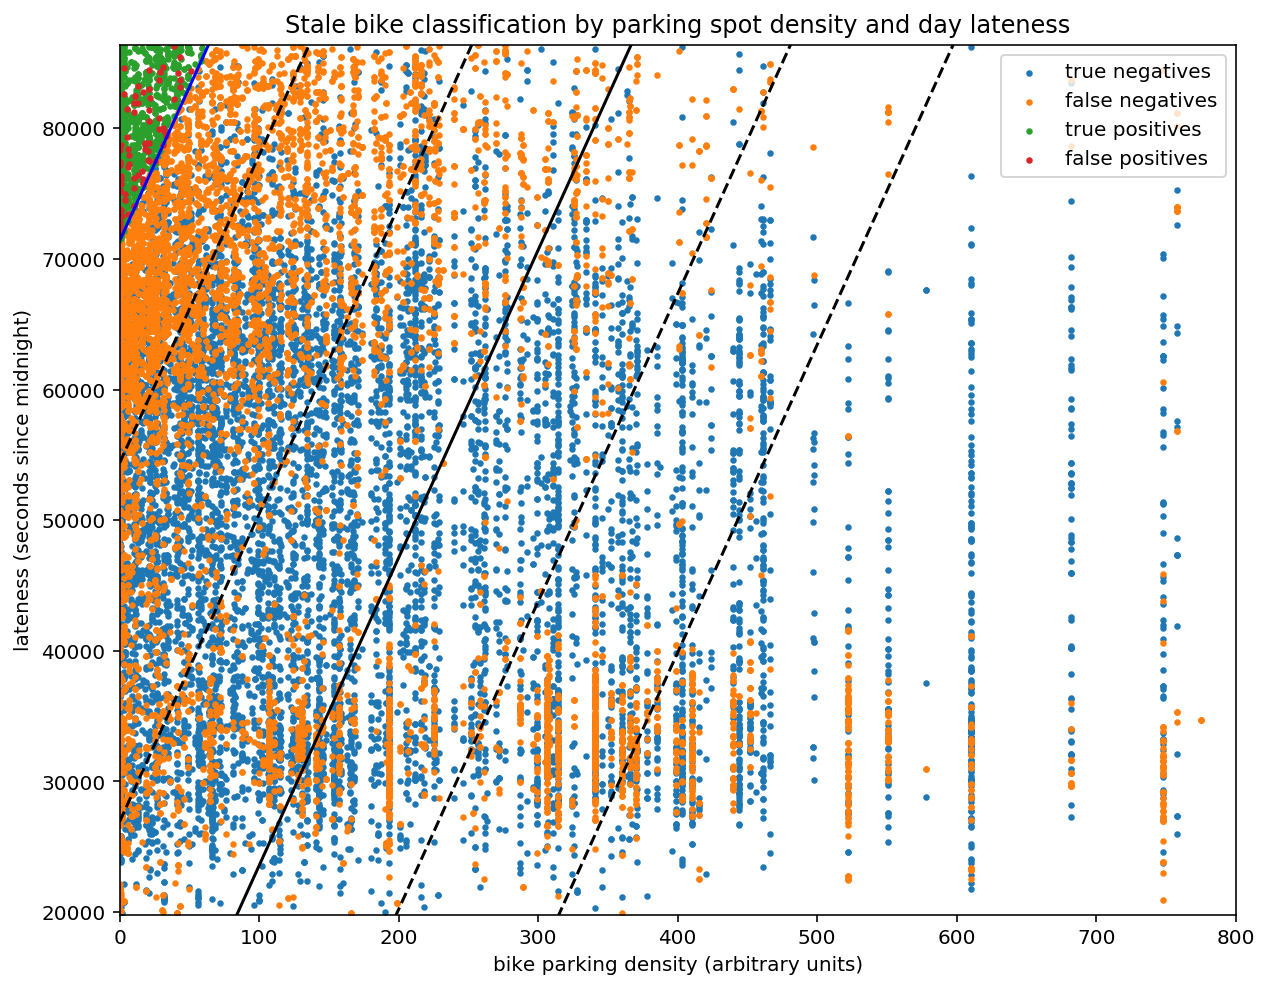

In [142]:
X_test_sub = X_test.copy()
y_test_sub = y_test.copy()

yhat_test = model.predict_proba(X_test_sub).T[1]

alpha = 0.63
s = 5

plt.figure(figsize=(10,8))

# true negatives
true_negative_mask = (yhat_test < alpha) & ~y_test_sub

X_true_neg = X_test_sub[true_negative_mask]
plt.scatter( X_true_neg[:,0], X_true_neg[:,1], s=s, cmap="rainbow", label="true negatives" )

# false negatives
false_negative_mask = (yhat_test < alpha) & y_test_sub

X_false_neg = X_test_sub[false_negative_mask]
plt.scatter( X_false_neg[:,0], X_false_neg[:,1], s=s, cmap="rainbow", label="false negatives" )

# true positives
true_positive_mask = (yhat_test >= alpha) & y_test_sub

X_true_pos = X_test_sub[true_positive_mask]
plt.scatter( X_true_pos[:,0], X_true_pos[:,1], s=s, cmap="rainbow", label="true positives" )

# false positives
false_positive_mask = (yhat_test >= alpha) & ~y_test_sub

X_false_pos = X_test_sub[false_positive_mask]
plt.scatter( X_false_pos[:,0], X_false_pos[:,1], s=s, cmap="rainbow", label="false positives" )


plt.xlabel("bike parking density (arbitrary units)")
plt.ylabel("lateness (seconds since midnight)")
plt.title("Stale bike classification by parking spot density and day lateness")
plt.xlim(df.density.min(), 800)
plt.ylim(df.starttimeseconds.min(), df.starttimeseconds.max())

xrange = np.linspace( df.density.min(), df.density.max() )
for i in [0.4, 0.45, 0.55, 0.6]:
    plt.plot(xrange, get_linear_separator(model, i)(xrange), "--", c="black" )
plt.plot(xrange, get_linear_separator(model, 0.5)(xrange), c="black" )

plt.plot(xrange, get_linear_separator(model, alpha)(xrange), c="blue" )

    
plt.legend()

In [143]:
tn = len( X_true_neg ) #true negatives
fn = len( X_false_neg ) #false negatives
tp = len( X_true_pos ) #true positives
fp = len( X_false_pos ) #false positives

tn, fn, tp, fp

(10143, 9138, 1027, 73)

In [144]:
confusion_matrix = np.array( [[tp, fp],
                              [fn, tn]] )
confusion_matrix

array([[ 1027,    73],
       [ 9138, 10143]])

Now the false positive rate is **wonderfully low**.

In [145]:
fpr = fp/(tn+fp)
fpr

0.007145653876272514

But, of course, the probability of detection **recall** has also tanked, because we're unwilling to make positive predictions:

In [146]:
recall = tp/(tp+fn)
recall

0.10103295622233154

This leads to another law of gravity: **as the classification threshold goes to 1, both FPR and TPR go to 0**. One is good, and the other bad, so it's a wash.

## Using FPR and TPR for model evaluation

So far we've evaluated the FPR and TPR at three different thresholds:

| threshold  | TPR "recall" |  FPR "false alarm rate" |
|---|---|---|
|  0.3 | 0.967  | 0.949   | 
|  0.5 | 0.76  | 0.61   |
|  0.65 | 0.0071  | 0.101   | 

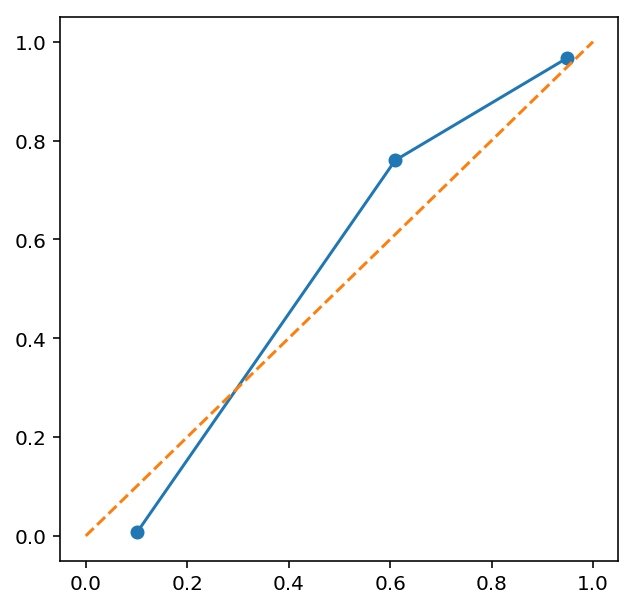

In [157]:
fpr = [0.949, 0.61, 0.101]
tpr = [0.967, 0.76, 0.0071]
plt.figure(figsize=(5,5))
plt.plot( fpr, tpr, "o-" )
plt.plot( [0,1],[0,1], "--" )

In fact, handy tools exist to compute the TPR and FPR over a large range of thresholds:

In [167]:
yhat_probs = model.predict_proba(X_test).T[1]
yhat_probs

array([0.48772252, 0.54005311, 0.43377916, ..., 0.51705847, 0.43561106,
       0.60455971])

In [178]:
fpr, tpr, thresholds = roc_curve( y_test, yhat_probs )

Text(0, 0.5, 'True positive rate')

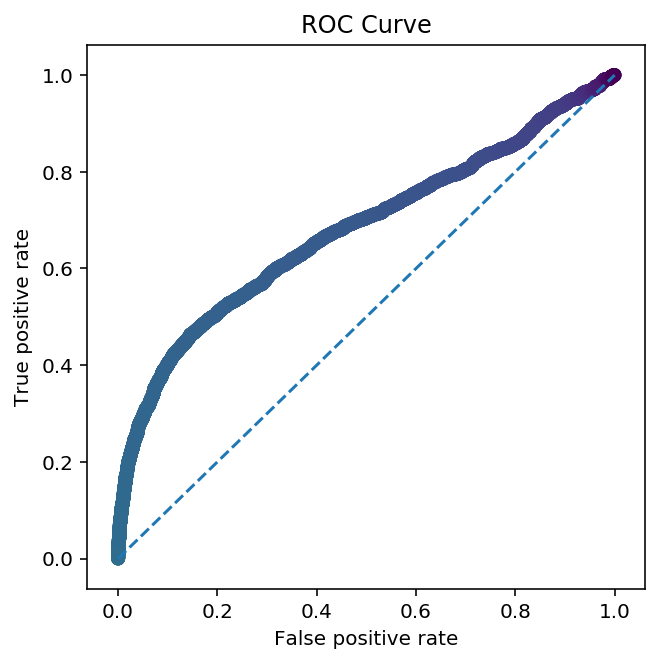

In [186]:
plt.figure(figsize=(5,5))
plt.scatter( fpr, tpr, c=thresholds/thresholds.max(), cmap="viridis" )
plt.plot( [0,1],[0,1], "--" )
plt.title( "ROC Curve" )
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

A quick tour:
* ROC stands for "receiver operating characteristic", a quirky term from WW2 radar science.
* The curve is pinned at the upper-right, when the model always predicts true, and both the FPR and TPR are 1.
 * What's the threshold to always predict true?
* The curve is pinned to the lower-left, when the model always predicts false, and bot the FPR and TPR are 0.
 * What's the threshold to always predict false?
* The slope is never negative at any point [0,1].
* A perfect classifier would have TPR=1 and FPR=1 for all thresholds except alpha=0 and alpha=1.
 * What would that look like?
 * What would the area under the curve be?
* What's the area under the curve of the worst possible classifier?

The area under the ROC curve is called the ROC-AUC score, because statisticans forgot about integrals the day this term was coined. The ROC-AUC score has the following lovely interpretation:

**Two observations picked at random from the population, with labels estimated by this model, would have chance p equal to the ROC-AUC score of being placed in the right order**.

* What is the best chance?
* What is the worst chance?

Consequently the ROC-AUC score gives an evaluation of the model's reliability to **rank** predictions, though not necessarily to give them the correct probabilities. Consequently the ROC-AUC score is tolerant to shenanigans, eg, logistic regression models trained on class-imbalanced dataset.
